In [1]:
from keras.callbacks import History
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.datasets import cifar10
from keras.engine import training
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Activation, Average
from keras.losses import categorical_crossentropy
from keras.models import Model, Input
from keras.optimizers import Adam
from keras.utils import to_categorical
from tensorflow.python.framework.ops import Tensor
from typing import Tuple, List
import glob
import numpy as np
import os

E:\Users\Arnab\Anaconda3\Lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.models import load_model
import keras

In [3]:
from keras.models import Model
import tensorflow as tf
    
def top_3_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k = 3)
dependencies = {
    'top_3_accuracy' : top_3_accuracy
}

#model1 = load_model('new_inception.h5')
#model2 = load_model('new_resnet_blekh.h5')
#model3 = load_model('bl_densenet.h5')
#model4 = load_model('new_inception_no_aug_blekha.h5')
#model5 = load_model('new_resnet_blekh_no_aug.h5')
#model6 = load_model('bl_densenet_no_aug.h5')
model1 = load_model('ins_corr.h5', custom_objects=dependencies)
model2 = load_model('bres.h5', custom_objects=dependencies)
model3 = load_model('bden.h5', custom_objects=dependencies)
model4 = load_model('ins_corr_no.h5', custom_objects=dependencies)
model5 = load_model('bres_no.h5', custom_objects=dependencies)
model6 = load_model('bden_no.h5', custom_objects=dependencies)

In [4]:

model1.name = '1'
model2.name = '2'
model3.name = '3'
model4.name = '4'
model5.name = '5'
model6.name = '6'

In [5]:
def ensembelModel(models, model_input):
    yModels = [model(model_input) for model in models]
    #outputs = [model.outputs[0] for model in models]
    #y = Average()(outputs)
    y = keras.layers.average(yModels)
    modelE = Model(inputs=model_input, outputs=y)
    return modelE

In [6]:
models = [model1, model2, model3, model4, model5, model6]
inputs = Input(shape=models[0].input_shape[1:])    
modelens = ensembelModel(models, inputs)
#modelens = ensembelModel([modelens1, modelens2, modelens3, modelens4, modelens5, modelens6], inputs)

In [7]:
modelens.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
1 (Model)                       (None, 84)           17627668    input_1[0][0]                    
__________________________________________________________________________________________________
2 (Model)                       (None, 84)           8960980     input_1[0][0]                    
__________________________________________________________________________________________________
3 (Model)                       (None, 84)           1350036     input_1[0][0]                    
__________________________________________________________________________________________________
4 (Model) 

In [8]:
modelens.save('final_ens.h5')

In [9]:
#model = load_model('ensembled.h5')

In [10]:
from keras.preprocessing.image import ImageDataGenerator
import time
from keras.callbacks import TensorBoard
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import csv
from keras.utils.vis_utils import plot_model
from keras.callbacks import History
from matplotlib import pyplot as plt


In [11]:
i=32
#train_data = ImageDataGenerator(rescale=1./255, validation_split = 0.2, rotation_range = 10, shear_range = .2 , zoom_range = .1, width_shift_range = .1, height_shift_range = .1)
test_data = ImageDataGenerator(rescale=1./255, validation_split = 0.2)

#training = train_data.flow_from_directory('Banglalekha',target_size=(i,i), batch_size=64,class_mode='categorical', subset='training')
test = test_data.flow_from_directory('Banglalekha',target_size=(i,i), batch_size=64,class_mode='categorical', subset='validation')

Found 32551 images belonging to 84 classes.


In [12]:
from keras.callbacks import History, LearningRateScheduler
import math


modelens.trainable = False

epochs = 50
def step_decay(epochs):
    initial_lrate = 0.0005
    drop = 0.5
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epochs)/epochs_drop))
    return lrate

lrate=LearningRateScheduler(step_decay)

opt= Adam()
modelens.compile(optimizer=opt, loss = "categorical_crossentropy", metrics= ["accuracy", top_3_accuracy])
#modelens.evaluate_generator(test)
#modelens.fit_generator(training, epochs=1, validation_data=test)

In [13]:
modelens.evaluate_generator(test)

[0.09294376742986395, 0.9755767871954779, 0.9973579920739762]

In [14]:
start = time.time()
testp = test_data.flow_from_directory('Banglalekha',target_size=(i,i), batch_size=64,class_mode='categorical', subset='validation',shuffle=False)        
start1 = time.time()
t_pred = modelens.predict_generator(testp)
end = time.time()
pred = np.argmax(t_pred, axis=1)
print(pred)
print('Confusion Matrix')
conf = confusion_matrix(testp.classes, pred)
print(conf)
print('Classification Report')
target_names = ['0', '1', '2', '3', '4', '5','6', '7', '8', '9']
for k in range(10,84):
    k1=k
    target_names.append(str(k1))
f1 = classification_report(testp.classes, pred, target_names=target_names)
print(f1)
print("\nDirectory and predict: ",end-start)
print("Predict: ",end-start1)

Found 32551 images belonging to 84 classes.
[ 0  0  0 ... 83 83 83]
Confusion Matrix
[[388   0   0 ...   0   0   0]
 [  0 386   0 ...   0   0   0]
 [  0   0 389 ...   0   0   2]
 ...
 [  1   0   0 ... 358   0   0]
 [  0   0   1 ...   0 375   0]
 [  0   0   1 ...   0   0 390]]
Classification Report
             precision    recall  f1-score   support

          0       0.98      0.99      0.99       392
          1       0.97      0.98      0.97       393
          2       0.99      0.99      0.99       392
          3       0.98      0.99      0.99       391
          4       0.98      0.96      0.97       387
          5       0.99      0.97      0.98       390
          6       0.94      0.96      0.95       380
          7       0.98      0.98      0.98       386
          8       0.98      0.98      0.98       390
          9       0.99      0.98      0.99       380
         10       1.00      1.00      1.00       387
         11       0.99      0.99      0.99       394
         12

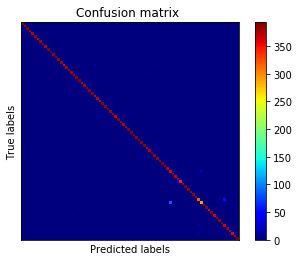

In [15]:
plt.imshow(conf, cmap=plt.cm.jet)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()
#print(model.summary())

In [16]:
cnt = 1
for i in conf:
    print(cnt)
    print(i)
    cnt = cnt +1

1
[388   0   0   0   0   0   0   0   0   0   0   2   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   1   0   0   0   0   0   0]
2
[  0 386   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0
   5   0   0   0   0   0   0   0   0   0   0   0]
3
[  0   0 389   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0  

In [17]:
cnt = 1
for i in conf:
    for j in range(0, len(i)):
        if((cnt != (j+1)) & (i[j] != 0)):
            print(str(cnt) + "   " + str(j+1) + " = " +str(i[j]))
    cnt = cnt + 1

1   12 = 2
1   33 = 1
1   78 = 1
2   50 = 1
2   71 = 1
2   73 = 5
3   45 = 1
3   84 = 2
4   27 = 1
4   70 = 1
5   7 = 5
5   21 = 5
5   24 = 1
5   31 = 1
5   37 = 1
5   75 = 1
6   1 = 1
6   12 = 1
6   19 = 4
6   26 = 2
6   30 = 1
6   37 = 1
7   5 = 1
7   21 = 2
7   30 = 1
7   31 = 7
7   36 = 1
7   37 = 3
7   78 = 1
8   29 = 3
8   42 = 1
8   46 = 1
8   53 = 2
9   17 = 1
9   18 = 4
9   55 = 1
10   22 = 1
10   38 = 2
10   60 = 2
10   63 = 1
10   64 = 1
12   1 = 1
12   79 = 1
13   59 = 1
14   73 = 1
16   15 = 1
16   31 = 1
16   83 = 2
17   8 = 1
17   29 = 20
17   39 = 1
17   50 = 1
17   52 = 8
17   53 = 2
17   73 = 1
18   4 = 1
18   9 = 6
18   20 = 1
19   6 = 3
19   25 = 8
19   26 = 2
19   57 = 1
20   9 = 1
20   18 = 1
20   50 = 7
20   71 = 1
21   5 = 3
21   31 = 2
21   58 = 1
21   75 = 3
22   18 = 1
22   80 = 1
23   34 = 3
23   38 = 1
24   5 = 1
24   16 = 2
24   28 = 3
24   32 = 1
24   67 = 2
24   70 = 1
25   19 = 10
25   30 = 1
25   33 = 1
25   37 = 2
26   25 = 1
26   33 = 2
27   4 = 3
29

In [18]:
truth = []

for i in range(208):
    x, y = next(testp)
    #predd.append(modelens.predict_generator(x, steps=64))
    truth.append(y) 

#predd = np.concatenate(predd)
truth = np.concatenate(truth)

In [19]:
truth.shape

(13312, 84)

In [20]:
y.shape[0]

64

In [21]:
pred_t = pred
pred_t.shape

(32551,)

In [22]:
import sys
import numpy
numpy.set_printoptions(threshold=20)

In [23]:
print(pred.shape)
pred1 = np.expand_dims(pred, axis=1) # make same shape as y_test
print(pred1)
b = np.zeros((pred1.size, pred1.max()+1))
b[np.arange(pred1.size),pred1] = 0
print(b)
print(truth)
error = np.sum(np.not_equal(b, truth)) / truth.shape[0] 

(32551,)
[[ 0]
 [ 0]
 [ 0]
 ...
 [83]
 [83]
 [83]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


ValueError: operands could not be broadcast together with shapes (32551,84) (13312,84) 

In [ ]:
error

In [ ]:
#import tensorflow as tf
#tf.enable_eager_execution()
cce = keras.losses.CategoricalCrossentropy()
cce(truth, b).numpy()

In [ ]:
import cv2

In [ ]:
img = cv2.imread('01_0001_0_15_0916_0438_2.png')

In [ ]:
img = cv2.resize(img, (32,32))

In [ ]:
img = np.reshape(img, [1, 32, 32, 3])

In [ ]:
classes = modelens.predict(img)
print(np.argmax(classes, axis=1))

In [24]:
import pandas as pd
df = pd.DataFrame(conf)

In [25]:
df

,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
0,388,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,386,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,389,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,0,0,0,389,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,373,0,5,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,380,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,1,0,364,0,0,0,...,0,0,0,1,0,0,0,0,0,0
7,0,0,0,0,0,0,0,379,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,384,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,373,...,0,0,0,0,0,0,0,0,0,0


In [26]:
df.to_csv('bl_conf.csv')